# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-21")


'''
Percentage change day on
'''
# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

'''
V. IMPORTANT- Use Sequential Split rather than typical random split, due to time series nature of data
'''

# Split data into training and test sets
training_size= int(len(scaled_data) * 0.8)
train_data = scaled_data[:training_size]
test_data=scaled_data[training_size:]



[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data

In [ ]:
test_data

array([[ 0.00111803],
       [-0.02138996],
       [-0.00412571],
       ...,
       [-0.00138891],
       [-0.02126919],
       [-0.00935577]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

Simple lag plot to determine input size

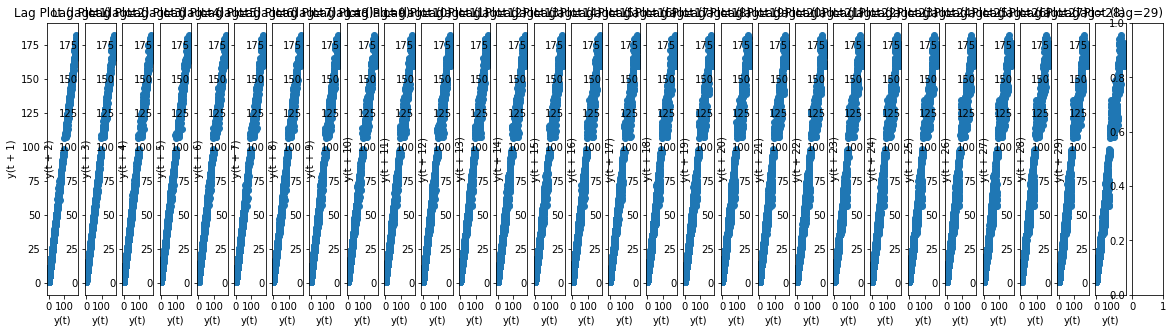

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 30, figsize=(20, 5))

for x in range(1, 30):
    pd.plotting.lag_plot(lag_plot, lag=x, ax=axs[x-1])
    axs[x-1].set_title(f"Lag Plot (lag={x})")

plt.show()

Plots suggest serial correlation up until at least 30th lag, so we will set input-size=30

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################

'''
create two arrays- y[i]  is the stock price on a particular day and x[i]
will be previous 30 day stock prices
'''

input_size = 30
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])
for i in range(0, len(y_train)):
    threshold = 0.0
    y_train[i] = np.where(y_train[i] > threshold, 1, 0)


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))



In [ ]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
#Examples
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(25))




model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6447/6447 [==============================] - 123s 18ms/step - loss: 0.2509
Epoch 2/3
6447/6447 [==============================] - 118s 18ms/step - loss: 0.2506
Epoch 3/3
6447/6447 [==============================] - 120s 19ms/step - loss: 0.2507


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
'''
test_data = scaled_data[training_data_len - input_size:, :]
'''


x_test = []
y_test = []

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(test_data[i, 0])

for i in range(0, len(y_test)):
    threshold = 0.0
    y_test[i] = np.where(y_test[i] > threshold, 1, 0)

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test_pred = model.predict(x_test)



50/50 [==============================] - 1s 10ms/step


In [ ]:
y_test_pred

array([[0.48462278],
       [0.48461357],
       [0.48462462],
       ...,
       [0.4846184 ],
       [0.48462614],
       [0.48462906]], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score


#Out of sample accuracy
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
y_test_pred = y_test_pred.reshape(-1, 1)
out_of_sample_acc = accuracy_score(y_test, y_test_pred)
print("Out of Sample Accuracy:", out_of_sample_acc)
#in sample accuracy
y_train_pred=model.predict(x_train)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
y_train_pred = y_train_pred.reshape(-1, 1)
in_sample_acc=accuracy_score(y_train, y_train_pred)
print("In sample Accuracy:", in_sample_acc)


Out of Sample Accuracy: 0.46729559748427674
202/202 [==============================] - 2s 10ms/step
In sample Accuracy: 0.5022491081123003


In [ ]:
#Random Walk Model

'''Intutition: Under RW model past prices can not be used to predict future prices
So, we use our model to predict a series of stock prices on a series of previous day prices
If the RW model holds, the accuracy of this prediction will be no better than chance, i.e around 50%
If the RW model does not hold then we would expect a decent accuracy score'''

# In-sample random walk
y_train_rw = y_train[1:]
y_train_pred_rw = y_train[:-1]
in_sample_rw_acc = accuracy_score(y_train_rw, y_train_pred_rw)
print("RW in Sample Accuracy:", in_sample_rw_acc)

# Out-of-sample random walk
y_test_rw = y_test[1:]
y_test_pred_rw = y_test[:-1]
out_of_sample_rw_acc = accuracy_score(y_test_rw, y_test_pred_rw)
print("RW out of Sample Accuracy:", out_of_sample_rw_acc)

RW in Sample Accuracy: 0.495035681042507
RW out of Sample Accuracy: 0.4883574575204531


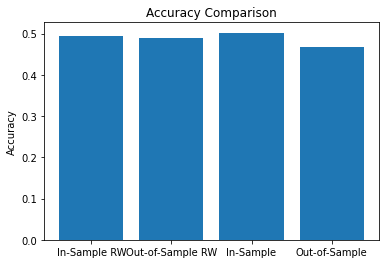

In [ ]:
# Plot the accuracies on a bar chart
labels = ['In-Sample RW', 'Out-of-Sample RW', 'In-Sample', 'Out-of-Sample']
values = [in_sample_rw_acc,  out_of_sample_rw_acc, in_sample_acc, out_of_sample_acc]

plt.bar(labels, values)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# 5.) Write an observation/conclusion about the graphs from Q4 and Q3

The fact that the RW model predicts the direction of the stock price based on past price information with approximately 50% accuracy, i.e no better than random chance suggests we cannot definitively conclude that Apple stock price does not follow a random walk process.


# 6.) Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

N/A